# Web Page Summarization - Improved

This is an NLP project that is designed to improve upon my last project. At its core, the project is designed to scrape multiple web pages and perform a summary analysis on the content. The previous project could only handle two web pages at a time, but this one will be handling ten. The websites being used are from Game Informer's website just like the last project. It will revisit the old project and introduce new NLP techniques like Latent Dirichlet Allocation (LDA) and Non-negative Matrix Factorization (NMF) as well as better cosine similarity visualization.

Old Project: https://github.com/phmartin93/CISB63-midterm

In [1]:
# Import the neccesary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import string
import requests
import re
import matplotlib.pyplot as plt

import spacy
from spacy import displacy

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, WordPunctTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist

from bs4 import BeautifulSoup
from wordcloud import WordCloud
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Download the nltk libraries to make sure everything is up-to-date
# nltk.download('wordnet')
# nltk.download('punkt')
# nltk.download('stopwords')

# Add the stopwords to a variable for later processing
stop_words = set(stopwords.words('english'))
# Load the spacy object for later visualization
nlp = spacy.load('en_core_web_sm')
# Display matplotlib graphs inline
%matplotlib inline

## EDA and Preprocessing

Here we will create functions to speed up the EDA and preprocessing steps so we can get to the new stuff faster. The preprocessing steps from the old project have been combined into a function since we will be working with ten web pages, which all need to be scraped and cleaned. These functions will be used throughout the document.

In [3]:
# Function to clean and tokenize the web page content
def get_page_content(url):
    # Create the tokenizer, lemmatizer, and regex pattern objects
    wpt = WordPunctTokenizer()
    lemmatizer = WordNetLemmatizer()
    # Removes all non-alphanumeric characters
    pattern = re.compile(r'[^a-zA-Z0-9\s]')
    
    # Send a request to retrieve the web page's content
    page = requests.get(url)
    # Retrieve the content is the request was accepted
    page_content = page.content
    # Use BeautifulSoup to parse the content
    soup = BeautifulSoup(page_content, 'html.parser')
    # Find all the p tags to get the content
    base_text = soup.find_all('p')
    # Get the text from the web page
    normal_text = [paragraph.get_text() for paragraph in base_text]
    # If-else statement to get rid of the unrelated text
    if normal_text[-4] == '\nView the discussion thread.\n':
        normal_text = normal_text[:-4]
    else:
        normal_text = normal_text[:-3]
    # Convert the text to lowercase
    lowercase_text = [text.lower() for text in normal_text]
    # Tokenize the text
    tokenized_text = [wpt.tokenize(text) for text in lowercase_text]
    # Remove the stopwords
    no_stop_text = [[word for word in tokens if word not in stop_words] for tokens in tokenized_text]
    # Lemmatize the text
    lem_text = [[lemmatizer.lemmatize(word) for word in tokens] for tokens in no_stop_text]
    # Remove special characters and punctuation
    regex_text = [[word for word in tokens if not pattern.match(word)] for tokens in lem_text]
    # Remove any empty tokens
    final_text = [[word for word in tokens if word.strip()] for tokens in regex_text]
    # Rejoin the tokens into sentences
    sentences = [' '.join(tokens) for tokens in final_text]
    # Join the text into a string
    paragraphs = '\n\n'.join(sentences)
    
    return paragraphs

In [4]:
# Function to get the titles of the web page
def get_title(url):
    # Send a request to retrieve the web page's content
    page = requests.get(url)
    # Retrieve the content is the request was accepted
    page_content = page.content
    # Use BeautifulSoup to parse the content
    soup = BeautifulSoup(page_content, 'html.parser')
    # Find the title of the web page
    title = soup.find_all('title')
    # Clean the title by removing the HTML tags
    clean_title = [text.get_text() for text in title]
    
    return clean_title[0]

Next we will quickly go through the summarization methods in the old project as a quick review of what the preprocessing functions are doing.

In [5]:
# Variable to store the URL of the web page being used
url = 'https://gameinformer.com/opinion/2023/10/25/the-path-to-an-avengers-video-game-should-have-always-gone-through-insomniacs'

# Call the prepocessing function to get the cleaned content
page_text = get_page_content(url)

print(page_text)

2008 robert downey jr debuted tony stark iron man outside excellent movie right iron man proved one influential film 21st century far paving way biggest film tv franchise last decade half marvel cinematic universe mcu post credit sequence iron man served teaser come samuel l jackson nick fury informed stark part bigger universe

time avenger initiative felt like throwaway tease something would never happen even involved writing scene film starring captain america thor hulk started building unprecedented interconnectivity announcement previously unthinkable avenger 2012 film one anticipated year worried might trying manage many moving part many plot many superheroes many superstar

fact five movie preceded iron man 1 2 incredible hulk thor captain america first avenger enough heavy lifting character storytelling convention avenger could home part mattered avenger huge success day serf case study build interconnected movie universe

others tried across various medium succeeded none succe

The content of the article was converted in lowercase, was lemmatized, had the stop words and non-alphanumeric characters removed, and turned into one large string.

# Old Visualization

Now that the content is cleaned, we can move on to the old visualization techniques. These include finding the most frequent occurring words and visualizing them using various graphs. We will also POS tag the tokens.

In [6]:
# Convert the text into tokens
#  Instead of two-dimensional list of tokens, this is a one-dimensional token list
clean_tokens = word_tokenize(page_text)

# Create a FreqDist object that will find the count frequency of the tokens
fdist = FreqDist(clean_tokens)

# Find the 20 most common words
common_words = fdist.most_common(20)

common_words

[('marvel', 38),
 ('man', 35),
 ('game', 33),
 ('spider', 28),
 ('avenger', 20),
 ('universe', 15),
 ('like', 14),
 ('film', 11),
 ('studio', 11),
 ('iron', 10),
 ('movie', 10),
 ('feel', 10),
 ('mcu', 9),
 ('way', 8),
 ('would', 7),
 ('even', 7),
 ('2', 7),
 ('insomniac', 7),
 ('one', 6),
 ('first', 6)]

In [7]:
# Create a pandas series using the most common words
word_series = pd.Series(dict(common_words))

# Sort the values in ascending order for the graph
word_series.sort_values(axis=0, ascending=True, inplace=True)

# Display the series head
word_series.head()

first        6
one          6
insomniac    7
2            7
even         7
dtype: int64

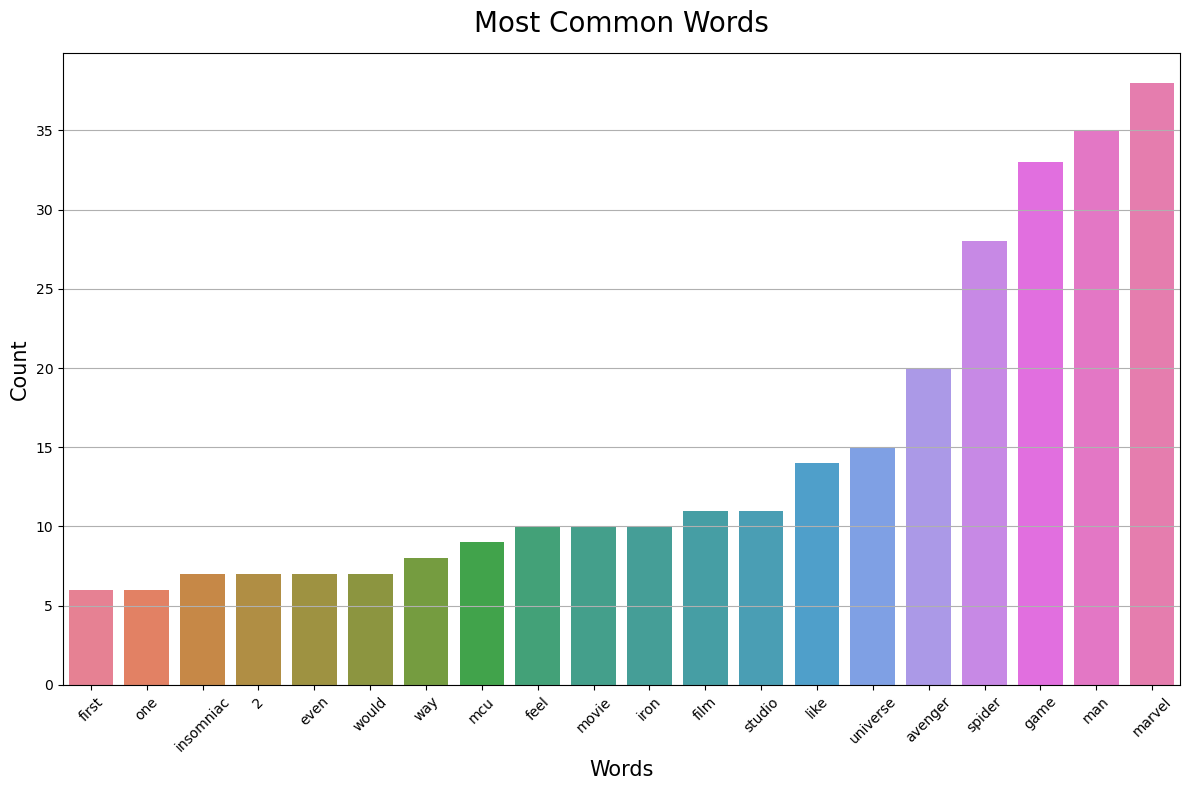

In [8]:
# Define the graph size
plt.figure(figsize=(12,8))
# Create a barplot using the series
sns.barplot(x=word_series.index, y=word_series.values, 
            hue=word_series.index, palette='husl', legend=False)
# Define title, x-axis label, and y-axis label
plt.title('Most Common Words', fontsize=20, pad=15)
plt.xlabel('Words', fontsize=15)
plt.ylabel('Count', fontsize=15)
# Rotate the x-tick labels so they are legible
plt.xticks(rotation=45)
# Add gridlines
plt.grid(axis='y')
# Display the graph
plt.tight_layout()
plt.show()

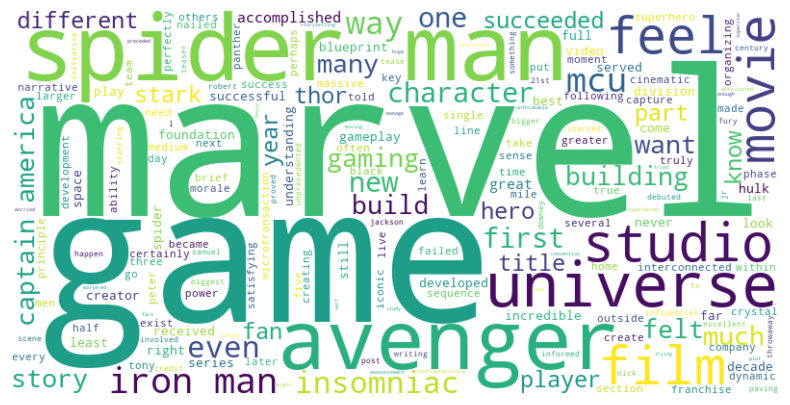

In [9]:
# Create a WordCloud object using the paragraphs variable
#  This is another way to visualize the most common words
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(page_text)

# Define the graph size
plt.figure(figsize=(10, 5))
# plot the word could into the graph
plt.imshow(wordcloud, interpolation="bilinear")
# Turn off axes
plt.axis("off")
# Show graph
plt.show()

In [10]:
# Use the spacy object created in the beginning to convert the text
doc = nlp(page_text)

# Use spacy's POS tagger to display the orginal text, its lemmatized form, and its POS tag
for token in doc:
    print(f'{token.text:<20} {token.lemma_:<20} {token.pos_:<10}')

2008                 2008                 NUM       
robert               robert               PROPN     
downey               downey               PROPN     
jr                   jr                   PROPN     
debuted              debut                VERB      
tony                 tony                 PROPN     
stark                stark                ADJ       
iron                 iron                 NOUN      
man                  man                  NOUN      
outside              outside              ADP       
excellent            excellent            ADJ       
movie                movie                NOUN      
right                right                ADJ       
iron                 iron                 NOUN      
man                  man                  NOUN      
proved               prove                VERB      
one                  one                  NUM       
influential          influential          ADJ       
film                 film                 NOUN

Everything is the same as the old project except for the POS tagging. I did not convert the text to lowercase last time, so the results might be slightly different, but it still looks like it did a decent job.

# New Preprocessing

This is where the new methods will start. First will get a list of URLs from the website. After that, two lists will be created. One list will be for the content of the web pages and the other will be for the titles. These lists are important since the vectorizers need something to iterate over to function properly.

In [11]:
# Create a list of web page URLs.
url_list = ['https://gameinformer.com/opinion/2023/10/25/the-path-to-an-avengers-video-game-should-have-always-gone-through-insomniacs',
           'https://www.gameinformer.com/2023/10/13/inside-the-rise-of-boomer-shooters',
           'https://www.gameinformer.com/opinion/2023/11/24/how-spider-man-2s-miles-morales-represents-community-black-culture-and-me',
           'https://www.gameinformer.com/exclusive-interview/2023/11/10/diablo-iv-leads-talk-development-process-post-launch-priorities',
           'https://www.gameinformer.com/2023/11/24/creature-feature-capturing-the-curious-story-of-palworld',
           'https://www.gameinformer.com/2023/11/29/the-challenging-climb-to-make-jusant',
           'https://www.gameinformer.com/2023/11/22/its-undeniably-going-to-cost-people-jobs-inside-the-game-industrys-fight-over-ai',
           'https://www.gameinformer.com/feature/2023/10/27/how-the-team-behind-cyberpunk-2077-phantom-libertys-score-created-a-spy-thriller',
           'https://www.gameinformer.com/opinion/2023/11/24/give-me-experiences-not-obligations',
           'https://www.gameinformer.com/2023/11/23/how-rgg-made-like-a-dragon-gaidens-new-secret-agent-combat']

In [12]:
# Create an empty list
content_list = []

# For loop to get the cleaned content of every web page
for item in url_list:
    temp = get_page_content(item)
    content_list.append(temp)

In [13]:
# Create an empty list
title_list = []

# For loop to get the title of every web page
for item in url_list:
    temp = get_title(item)
    title_list.append(temp[:-16])

# New EDA

Some new methods will be used for topic extraction rather than finding the words with the highest frequency. Topic extraction allows us to extract meaning from text by identifying recurrent themes or topics. LDA and NMF will be used to see which one is better for this task. The variables will be as consistent as possible to make sure both methods are tested fairly.

In [14]:
# Define the number of topics
#  10 topics for our 10 web pages
num_topics = 10

# Create a TfidfVectorizer object
#  We will be using TfidfVectorizer since the TF-IDF determines the frequency of a word in a document in relation to the whole corpus
#  TF-IDF will put more weight on words it deems more important for the document
#  Lowercase is false because we already did that
#  max_df is 0.95 to filter out more common words that might not have much relevance
#  min_df is 1 to filter out less frequent words, but still retain the document's unique words
vectorizer = TfidfVectorizer(stop_words='english', lowercase=False, max_df=0.95, min_df=1)
# Create a document term matrix by fitting the document list with the vectorizer
#  The model requires a DTM in order to function properly
dtm = vectorizer.fit_transform(content_list)

In [15]:
# Create the LDA model
#  Random state is 42 to keep our tests consistent
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
# Fit the DTM to the model
lda_matrix = lda.fit_transform(dtm)

In [16]:
# Get the topics and the top words in each topic
feature_names_lda = np.array(vectorizer.get_feature_names_out())

# For loop to iterate through the different topics and top words extracted by the LDA model
for topic_idx, topic in enumerate(lda.components_):
    top_words_indices = topic.argsort()[-10:][::-1]
    top_words = feature_names_lda[top_words_indices]
    print(f"Topic #{topic_idx + 1}: {', '.join(top_words)}")

Topic #1: obligation, free, engagement, longer, play, experience, skin, engaging, engage, goal
Topic #2: doom, mile, museum, quest, boomer, shooter, oshry, dusk, man, fps
Topic #3: marvel, man, spider, avenger, style, gadget, sakamoto, kiryu, yakuza, combat
Topic #4: caplain, say, jusant, nod, climbing, generative, saheb, company, art, human
Topic #5: informer, set, played, developer, world, line, early, use, review, mean
Topic #6: season, thing, diablo, lane, really, change, feedback, team, swim, kind
Topic #7: informer, set, played, developer, world, line, early, use, review, mean
Topic #8: phantom, liberty, adamczyk, cyberpunk, music, soundtrack, score, paciorkowski, edgerunners, cdpr
Topic #9: informer, set, played, developer, world, line, early, use, review, mean
Topic #10: palworld, pal, mizobe, pocketpair, pokémon, survival, craftopia, free, weapon, player


LDA is a probabilistic model, meaning the data is based on probabilities. There is an element of randomness to it. We can see that at work in the topics. Topics 5, 7, and 9 are the same, meaning not all of our web pages were used in the ten components. For this task, this is not ideal.

We will try NMF next to see if we can get a better result. The same vectorizer and DTM will be used so we will go straight to the NMF model.

In [18]:
# Create the NMF model
#  init is random to randomize the matrices values for W and H
nmf = NMF(n_components=num_topics, init='random', random_state=42)
# Fit the DTM to the model
nmf_matrix = nmf.fit_transform(dtm) 

In [19]:
# Get the topics and the top words in each topic
feature_names = vectorizer.get_feature_names_out()

# For loop to iterate through the different topics and top words extracted by the LDA model
for topic_idx, topic in enumerate(nmf.components_):
    top_words_indices = topic.argsort()[-10:][::-1]
    top_words = [feature_names[i] for i in top_words_indices]
    print(f"Topic #{topic_idx + 1}: {', '.join(top_words)}")

Topic #1: palworld, pal, mizobe, pocketpair, survival, pokémon, craftopia, free, weapon, player
Topic #2: season, thing, diablo, lane, really, feedback, change, team, swim, kind
Topic #3: style, sakamoto, gadget, yakuza, kiryu, combat, fighting, rgg, agent, action
Topic #4: obligation, free, longer, engagement, play, experience, engaging, engage, skin, goal
Topic #5: marvel, spider, man, avenger, universe, film, mcu, iron, movie, insomniac
Topic #6: generative, say, company, human, executive, chatgpt, ghostwriter, diffusion, image, art
Topic #7: caplain, jusant, nod, climbing, saheb, mountain, player, say, team, heavy
Topic #8: mile, museum, quest, man, spider, black, character, jazz, harlem, instrument
Topic #9: doom, boomer, shooter, dusk, oshry, fps, evil, amid, clone, quake
Topic #10: phantom, liberty, adamczyk, cyberpunk, music, soundtrack, score, paciorkowski, edgerunners, cdpr


While the order was randomized, each topic is unique, and by reading the top words, we can identify which article was most likely used. Each topic seems to have a unique set of top words. The articles used were very different from each other on purpose, so this is a good sign.

The NMF topics and top words will be used for the comparison.

# New Visualization

Next the data will be visualized so conclusions can be drawn. Word clouds will be generated for each web page. The top words from the NMF will be compared to them.

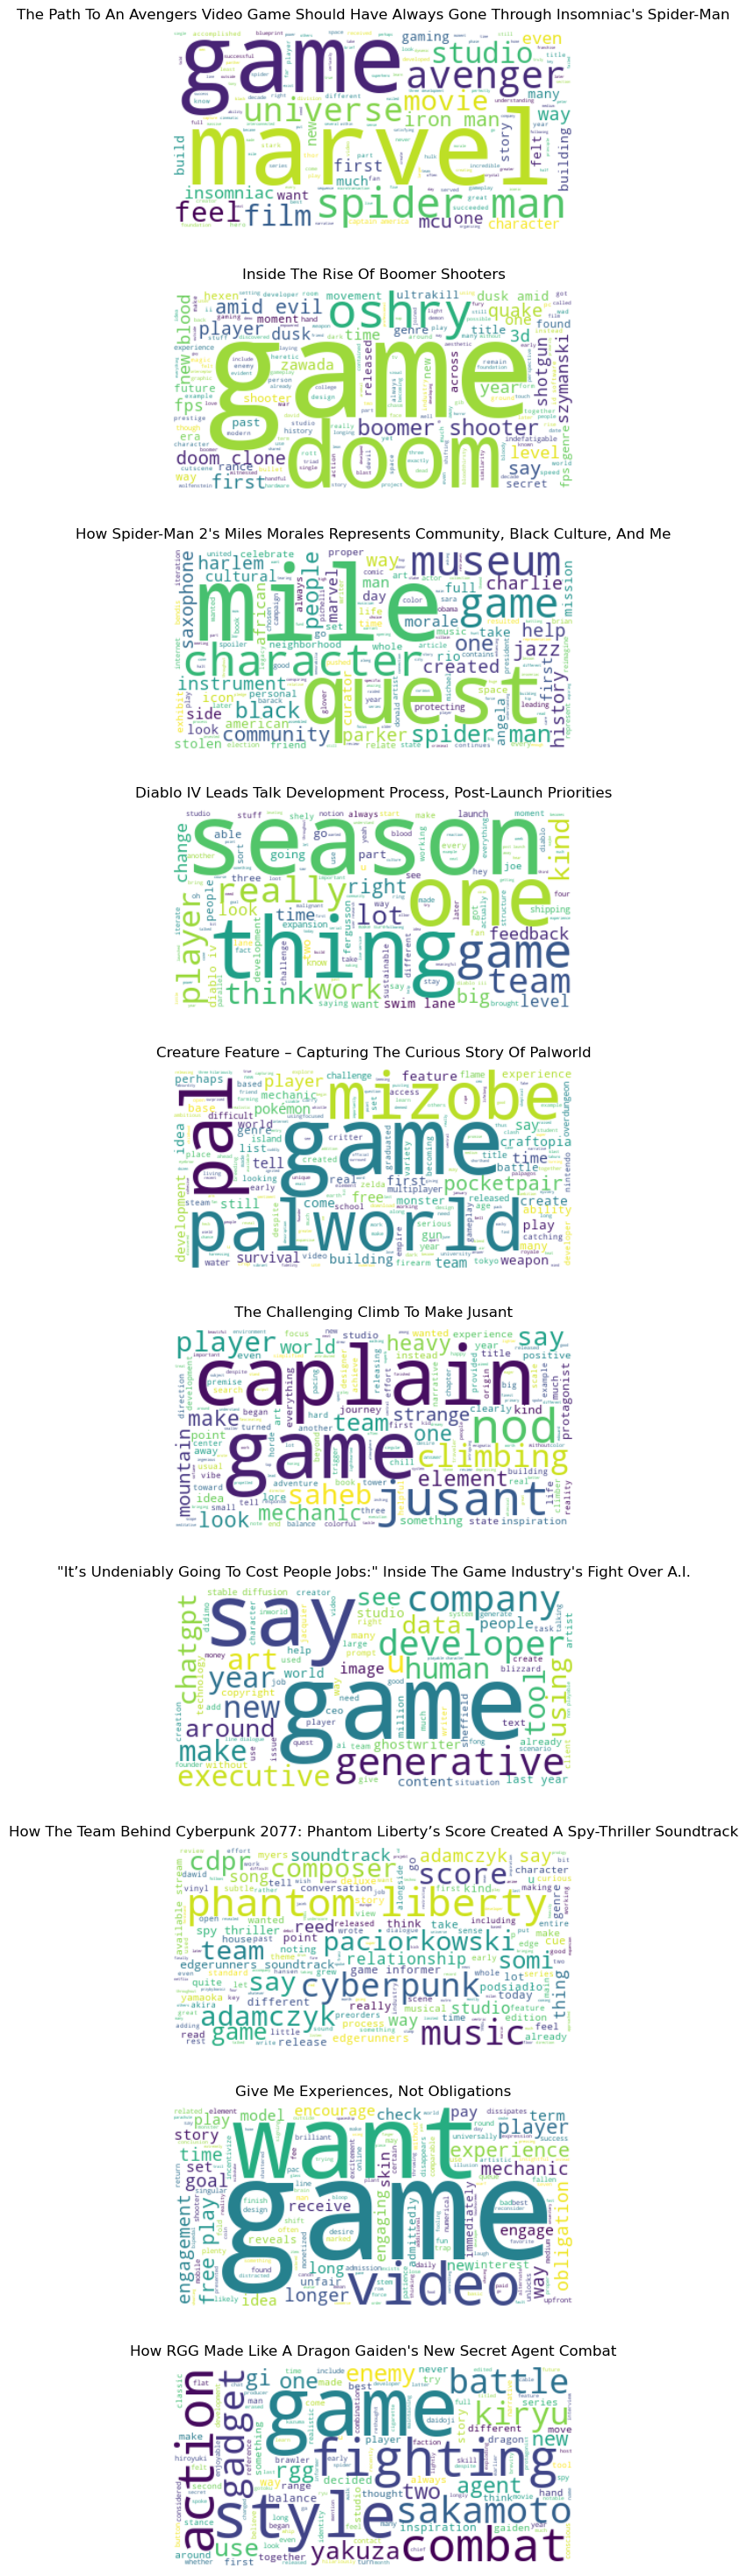

In [20]:
fig, axs = plt.subplots(10, figsize=(10,30))

for i in range(len(content_list)):
    wc = WordCloud(background_color='white').generate(content_list[i])
    axs[i].imshow(wc, interpolation='bilinear')
    axs[i].axis('off')
    axs[i].set_title(title_list[i], pad=10)

fig.tight_layout(pad=3)
plt.show()

One thing that is noticeable is that each word cloud prominently features the word 'game,' which makes sense considering these are articles taken from a website that specializes in video game content. However, 'game' is absent from the top words from the NMF model. This is because of the parameters that were set. The max_df parameter most likely eliminated 'game' from the pool because of its high frequency. Other than that, the rest of the word clouds seem to line up with their respective top words. It is not an exact match, but it is still close.

Next we will look at the cosine similarity between all the articles.

In [21]:
# Create a TfidfVectorizer object
#  TF-IDF determines the frequency of a word in a document in relation to the whole corpus
#  The TF-IDF score is what the cosine similarity will use to determine how similar the web pages are to each other
tfidf = TfidfVectorizer(stop_words='english')
# Fit and transform the text to count vectors
vect_matrix = tfidf.fit_transform(content_list)

# Create the document term matrix
dtm = vect_matrix.todense()
# Turn the matrix into a dataframe to visualize the data
#  The cosine similarity function will be able to handle a DTM or a dataframe
df = pd.DataFrame(dtm, 
                  columns=tfidf.get_feature_names(),
                  index=title_list)

In [22]:
# Display the dataframe head
df.head()

,000,007,10,100,11,12,14,1900s,1960s,1980s,...,youth,yves,zawada,zee,zeitgeist,zelda,zero,zir,zone,zoom
The Path To An Avengers Video Game Should Have Always Gone Through Insomniac's Spider-Man,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.00000,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
Inside The Rise Of Boomer Shooters,0.012078,0.0,0.013805,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.01624,0.0,0.097439,0.01624,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
"How Spider-Man 2's Miles Morales Represents Community, Black Culture, And Me",0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.042378,0.0,0.0,...,0.00000,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
"Diablo IV Leads Talk Development Process, Post-Launch Priorities",0.009454,0.0,0.000000,0.018908,0.000000,0.000000,0.012712,0.000000,0.0,0.0,...,0.00000,0.0,0.000000,0.00000,0.012712,0.000000,0.000000,0.025423,0.000000,0.0
Creature Feature – Capturing The Curious Story Of Palworld,0.000000,0.0,0.000000,0.018047,0.048531,0.020628,0.000000,0.000000,0.0,0.0,...,0.00000,0.0,0.000000,0.00000,0.000000,0.048531,0.024266,0.000000,0.020628,0.0


In [23]:
# Calculate the cosine similarity
cos_sim = cosine_similarity(df, df)

# Round the values for readability
for i in range(len(cos_sim)):
    for j in range(len(cos_sim[i])):
        cos_sim[i][j]=np.round(cos_sim[i][j], 4)

In [24]:
# Turn the cosine matrix into a dataframe for data visualization
df2 = pd.DataFrame(cos_sim,
                  columns = title_list,
                  index=title_list)
# Display dataframe
df2

,The Path To An Avengers Video Game Should Have Always Gone Through Insomniac's Spider-Man,Inside The Rise Of Boomer Shooters,"How Spider-Man 2's Miles Morales Represents Community, Black Culture, And Me","Diablo IV Leads Talk Development Process, Post-Launch Priorities",Creature Feature – Capturing The Curious Story Of Palworld,The Challenging Climb To Make Jusant,"""It’s Undeniably Going To Cost People Jobs:"" Inside The Game Industry's Fight Over A.I.",How The Team Behind Cyberpunk 2077: Phantom Liberty’s Score Created A Spy-Thriller Soundtrack,"Give Me Experiences, Not Obligations",How RGG Made Like A Dragon Gaiden's New Secret Agent Combat
The Path To An Avengers Video Game Should Have Always Gone Through Insomniac's Spider-Man,1.0000,0.0942,0.2523,0.0750,0.0859,0.0671,0.1303,0.0534,0.1169,0.1265
Inside The Rise Of Boomer Shooters,0.0942,1.0000,0.0568,0.0871,0.1111,0.0870,0.1466,0.0587,0.1280,0.1247
"How Spider-Man 2's Miles Morales Represents Community, Black Culture, And Me",0.2523,0.0568,1.0000,0.0616,0.0542,0.0564,0.1156,0.0585,0.0811,0.0616
"Diablo IV Leads Talk Development Process, Post-Launch Priorities",0.0750,0.0871,0.0616,1.0000,0.0951,0.1079,0.1273,0.0976,0.0959,0.0939
Creature Feature – Capturing The Curious Story Of Palworld,0.0859,0.1111,0.0542,0.0951,1.0000,0.1124,0.1577,0.0619,0.1477,0.1347
The Challenging Climb To Make Jusant,0.0671,0.0870,0.0564,0.1079,0.1124,1.0000,0.1253,0.0664,0.1053,0.0973
"""It’s Undeniably Going To Cost People Jobs:"" Inside The Game Industry's Fight Over A.I.",0.1303,0.1466,0.1156,0.1273,0.1577,0.1253,1.0000,0.1040,0.1673,0.1567
How The Team Behind Cyberpunk 2077: Phantom Liberty’s Score Created A Spy-Thriller Soundtrack,0.0534,0.0587,0.0585,0.0976,0.0619,0.0664,0.1040,1.0000,0.0537,0.0668
"Give Me Experiences, Not Obligations",0.1169,0.1280,0.0811,0.0959,0.1477,0.1053,0.1673,0.0537,1.0000,0.1284
How RGG Made Like A Dragon Gaiden's New Secret Agent Combat,0.1265,0.1247,0.0616,0.0939,0.1347,0.0973,0.1567,0.0668,0.1284,1.0000


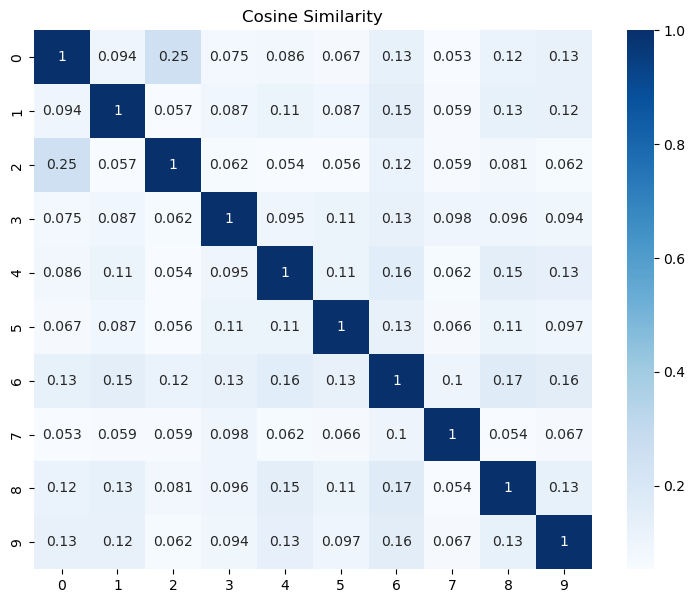

0 - The Path To An Avengers Video Game Should Have Always Gone Through Insomniac's Spider-Man
1 - Inside The Rise Of Boomer Shooters
2 - How Spider-Man 2's Miles Morales Represents Community, Black Culture, And Me
3 - Diablo IV Leads Talk Development Process, Post-Launch Priorities
4 - Creature Feature – Capturing The Curious Story Of Palworld
5 - The Challenging Climb To Make Jusant
6 - "It’s Undeniably Going To Cost People Jobs:" Inside The Game Industry's Fight Over A.I.
7 - How The Team Behind Cyberpunk 2077: Phantom Liberty’s Score Created A Spy-Thriller Soundtrack
8 - Give Me Experiences, Not Obligations
9 - How RGG Made Like A Dragon Gaiden's New Secret Agent Combat


In [31]:
# Create a heatmap for better data visualization
plt.figure(figsize=(9,7))
sns.heatmap(cos_sim, annot=True, cmap='Blues')
plt.title('Cosine Similarity')
plt.show()

# For loop to print the title and its index
#  Self-made legend
for i in range(len(title_list)):
    print(f'{i} - {title_list[i]}')

The cosine similarities of all the web pages can be compared using the dataframe or heatmap. Most of the scores are low, which is good because the chosen articles have different topics on purpose. This means it is working.

The highest score is 0.25. This score is between the only two Spider-Man articles, so it makes sense why it is the highest. The score is still low since the topics are different subjects. They just have a minor overlapping subject, Spider-Man.

# Conclusion

This project was meant to improve upon the old one. I believe this was accomplished. Rather than just having the most frequent occurring words, I was able to find and list top words by weight/importance to the article, which gave the summarization a lot more meaning. The cosine similarity visualization was also improved and performed as expected.